# Benchmarking Auto-Completion Models

This notebook compares various representations of the same model in order to investigate the benefits of quantisation and other optimisations, comparing performance of CPU- and GPU-based execution.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from time import time

import numpy as np
import pandas as pd
import torch.cuda

from autodev.util import logging
from autodev.autocomplete.completion_model import CompletionModel
from autodev.autocomplete.completion_task import CompletionTask
from autodev.autocomplete.model import SantaCoderModelFactory, ModelTransformationBetterTransformer, \
    ModelTransformation
from autodev.util.resource_usage import ResourceUsageMonitoringThread

log = logging.getLogger(__name__)
logging.configure()

/home/aaiuser/remote-autodev/src/autodev/__init__.py:58: UserWarning: Patching transformers.TextGenerationPipeline._forward because of a bug that requires all pipeline arguments to be serializable.
  warnings.warn("Patching transformers.TextGenerationPipeline._forward because of a bug that requires all pipeline arguments to be serializable.")


In [2]:
# configuration parameters
num_applications = 5
num_burnin_applications = 1

In [3]:
# load completion tasks
prefix = "def add(x, y):\n"
completion_tasks = [CompletionTask.from_file(p, "python") for p in Path("data/completion-tasks/python").iterdir()]
log.info(f"{len(completion_tasks)} completion tasks loaded")

INFO  2023-07-21 15:26:09,871 __main__:<module> - 2 completion tasks loaded


In [4]:
# define models to be benchmarked
mf = SantaCoderModelFactory()
tokenizer = mf.create_tokenizer()

def create_model(path, device, nocache=False, transform: ModelTransformation = None):
    model = mf.create_model(path, transformation=transform)
    if nocache:
        if model.config.use_cache:
            model.config.use_cache = False
        else:
            raise ValueError("Model does not use cache to begin with")
    return CompletionModel(model, tokenizer, device=device)

transformers_model_path = "bigcode/santacoder"
onnx_model_path = "models/santacoder_onnx"
onnx_avx2_model_path = "models/santacoder_onnx_avx2"
onnx_avx512_model_path = "models/santacoder_onnx_avx512"
onnx_avx512_vnni_model_path = "models/santacoder_onnx_avx512-vnni"
bt = ModelTransformationBetterTransformer()
models = {
    "transformers-cached-cpu": (lambda: create_model(transformers_model_path, "cpu")),
    "transformers-cpu": (lambda: create_model(transformers_model_path, "cpu", nocache=True)),
    "onnxruntime-cpu": (lambda: create_model(onnx_model_path, "cpu")),
    #"onnxruntime-cpu-avx2": (lambda: create_model(onnx_avx2_model_path, "cpu")),
    "onnxruntime-cpu-avx512": (lambda: create_model(onnx_avx512_model_path, "cpu")),
    "onnxruntime-cpu-avx512-vnni": (lambda: create_model(onnx_avx512_vnni_model_path, "cpu")),
    "bettertransformer-cached-cpu": (lambda: create_model(transformers_model_path, "cpu", transform=bt)),
}
if torch.cuda.is_available():
    device = "cuda:0"
    models.update({
        "transformers-cached-gpu": (lambda: create_model(transformers_model_path, device)),
        "transformers-gpu": (lambda: create_model(transformers_model_path, device, nocache=True)),
        "onnxruntime-gpu": (lambda: create_model(onnx_model_path, device)),
        "bettertransformer-cached-gpu": (lambda: create_model(transformers_model_path, device, transform=bt)),
    })

INFO  2023-07-21 15:26:10,227 __main__:<module> - 13 models will be benchmarked


In [5]:
# apply benchmarking
monitoring_thread = ResourceUsageMonitoringThread()
monitoring_thread.start()
rows = []
for model_name, cm_factory in models.items():
    log.info(f"Starting evaluation of {model_name}")
    tstart = time()
    completion_model: CompletionModel = cm_factory()
    load_time = time() - tstart
    num_chars = 0
    for i in range(num_applications + num_burnin_applications):
        if i == num_burnin_applications:
            monitoring_thread.begin_collection(model_name)
            tstart = time()
            num_chars = 0
        for completion_task in completion_tasks:
            result = completion_model.apply(completion_task)
            num_chars += len(result.completion)
    time_taken = time() - tstart
    log.info(f"{model_name}: time taken = {time_taken}s")
    resource_usage = monitoring_thread.end_collection()
    row = dict(model_name=model_name, time_taken=time_taken, num_chars=num_chars,
        secs_per_task=time_taken/(num_applications*len(completion_tasks)), load_time=load_time,
        cpu_usage=resource_usage.cpu_utilization_percent(agg=np.median),
        gpu_usage=resource_usage.gpu_utilization_percent(agg=np.median),
        ram_gb=resource_usage.system_memory_usage_mb(agg=np.median) / 1000,
        vram_gb=resource_usage.gpu_memory_usage_mb(agg=np.median) / 1000)
    log.info(f"{row}")
    rows.append(row)
    del completion_model

INFO  2023-07-21 15:26:10,287 __main__:<module> - Starting evaluation of transformers-cached_cpu


The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-21 15:27:17,735 __main__:<module> - transformers-cached_cpu: time taken = 35.224125385284424s
INFO  2023-07-21 15:27:17,737 __main__:<module> - {'model_name': 'transformers-cached_cpu', 'time_taken': 35.224125385284424, 'num_chars': 720, 'secs_per_task': 3.5224125385284424, 'load_time': 26.24775791168213, 'cpu_usage': 89.5, 'gpu_usage': 0.0, 'ram_gb': 7.530000384, 'vram_gb': 0.0}
INFO  2023-07-21 15:27:17,981 __main__:<module> - Starting evaluation of transformers_cpu


The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-21 15:31:16,490 __main__:<module> - transformers_cpu: time taken = 185.6043016910553s
INFO  2023-07-21 15:31:16,493 __main__:<module> - {'model_name': 'transformers_cpu', 'time_taken': 185.6043016910553, 'num_chars': 720, 'secs_per_task': 18.56043016910553, 'load_time': 21.578973531723022, 'cpu_usage': 89.9, 'gpu_usage': 0.0, 'ram_gb': 9.013051392, 'vram_gb': 0.0}
INFO  2023-07-21 15:31:16,746 __main__:<module> - Starting evaluation of onnxruntime_cpu
INFO  2023-07-21 15:31:16,750 autodev.autocomplete.model:create_model - Loading ONNX model from models/santacoder_onnx/model.onnx
INFO  2023-07-21 15:33:27,416 __main__:<module> - onnxruntime_cpu: time taken = 96.56326150894165s
INFO  2023-07-21 15:33:27,419 __main__:<module> - {'model_name': 'onnxruntime_cpu', 'time_taken': 96.56326150894165, 'num_chars': 720, 'secs_per_task': 9.656326150894165, 'load_time': 17.566232442855835, 'cpu_usage': 100.0, 'gpu_usage': 0.0, 'ram_gb': 8.656809983999999, 'vram_gb': 0.0}
INFO  2023-07-

The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-21 15:43:29,485 __main__:<module> - bettertransformer-cached_cpu: time taken = 33.874855279922485s
INFO  2023-07-21 15:43:29,488 __main__:<module> - {'model_name': 'bettertransformer-cached_cpu', 'time_taken': 33.874855279922485, 'num_chars': 720, 'secs_per_task': 3.3874855279922484, 'load_time': 29.13126230239868, 'cpu_usage': 89.3, 'gpu_usage': 0.0, 'ram_gb': 13.731667968, 'vram_gb': 0.0}
INFO  2023-07-21 15:43:29,488 __main__:<module> - Starting evaluation of transformers-cached_gpu


The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-21 15:44:10,157 __main__:<module> - transformers-cached_gpu: time taken = 7.523850440979004s
INFO  2023-07-21 15:44:10,160 __main__:<module> - {'model_name': 'transformers-cached_gpu', 'time_taken': 7.523850440979004, 'num_chars': 720, 'secs_per_task': 0.7523850440979004, 'load_time': 31.183525323867798, 'cpu_usage': 15.5, 'gpu_usage': 26.0, 'ram_gb': 15.418544127999999, 'vram_gb': 5.348}
INFO  2023-07-21 15:44:10,163 __main__:<module> - Starting evaluation of transformers_gpu


The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-21 15:44:42,196 __main__:<module> - transformers_gpu: time taken = 8.48026704788208s
INFO  2023-07-21 15:44:42,198 __main__:<module> - {'model_name': 'transformers_gpu', 'time_taken': 8.48026704788208, 'num_chars': 720, 'secs_per_task': 0.848026704788208, 'load_time': 21.909170150756836, 'cpu_usage': 15.3, 'gpu_usage': 49.0, 'ram_gb': 10.508406784, 'vram_gb': 5.472}
INFO  2023-07-21 15:44:42,202 __main__:<module> - Starting evaluation of onnxruntime_gpu
INFO  2023-07-21 15:44:42,205 autodev.autocomplete.model:create_model - Loading ONNX model from models/santacoder_onnx/model.onnx


2023-07-21 15:44:56.413093938 [W:onnxruntime:, session_state.cc:1169 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2023-07-21 15:44:56.413172347 [W:onnxruntime:, session_state.cc:1171 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
/home/aaiuser/miniconda3/envs/autodev/lib/python3.10/site-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/home/aaiuser/miniconda3/envs/autodev/lib/python3.10/site-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


INFO  2023-07-21 15:45:06,931 __main__:<module> - onnxruntime_gpu: time taken = 6.676137447357178s
INFO  2023-07-21 15:45:06,933 __main__:<module> - {'model_name': 'onnxruntime_gpu', 'time_taken': 6.676137447357178, 'num_chars': 720, 'secs_per_task': 0.6676137447357178, 'load_time': 16.494483709335327, 'cpu_usage': 15.9, 'gpu_usage': 65.0, 'ram_gb': 10.329104384, 'vram_gb': 13.794}
INFO  2023-07-21 15:45:06,935 __main__:<module> - Starting evaluation of onnxruntime-cached_gpu


2023-07-21 15:45:27.739450791 [W:onnxruntime:, session_state.cc:1169 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2023-07-21 15:45:27.739503006 [W:onnxruntime:, session_state.cc:1171 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2023-07-21 15:45:32.368197921 [W:onnxruntime:, session_state.cc:1169 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2023-07-21 15:45:32.368235367 [W:onnxruntime:, session_state.cc:1171 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
/home/aaiuser/miniconda3/envs/autodev/li

INFO  2023-07-21 15:46:42,673 __main__:<module> - onnxruntime-cached_gpu: time taken = 56.79656910896301s
INFO  2023-07-21 15:46:42,676 __main__:<module> - {'model_name': 'onnxruntime-cached_gpu', 'time_taken': 56.79656910896301, 'num_chars': 3130, 'secs_per_task': 5.679656910896301, 'load_time': 27.62670135498047, 'cpu_usage': 15.7, 'gpu_usage': 28.000000000000004, 'ram_gb': 10.367680512000002, 'vram_gb': 22.018}
INFO  2023-07-21 15:46:42,677 __main__:<module> - Starting evaluation of bettertransformer-cached_gpu
WARNING 2023-07-21 15:47:04,217 root:transform - For training, the BetterTransformer implementation for gpt2  architecture currently does not support padding as fused kernels do not support custom attention masks. Beware that passing padded batched training data may result in unexpected outputs.


The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-21 15:47:14,689 __main__:<module> - bettertransformer-cached_gpu: time taken = 7.688399791717529s
INFO  2023-07-21 15:47:14,691 __main__:<module> - {'model_name': 'bettertransformer-cached_gpu', 'time_taken': 7.688399791717529, 'num_chars': 720, 'secs_per_task': 0.768839979171753, 'load_time': 22.81495499610901, 'cpu_usage': 15.3, 'gpu_usage': 25.0, 'ram_gb': 10.567481343999999, 'vram_gb': 22.018}


In [6]:
df = pd.DataFrame(rows).sort_values("secs_per_task").reset_index()
df

,index,model_name,time_taken,num_chars,secs_per_task,load_time,cpu_usage,gpu_usage,ram_gb,vram_gb
0,10,onnxruntime_gpu,6.676137,720,0.667614,16.494484,15.9,65.0,10.329104,13.794
1,8,transformers-cached_gpu,7.523850,720,0.752385,31.183525,15.5,26.0,15.418544,5.348
2,12,bettertransformer-cached_gpu,7.688400,720,0.768840,22.814955,15.3,25.0,10.567481,22.018
3,9,transformers_gpu,8.480267,720,0.848027,21.909170,15.3,49.0,10.508407,5.472
4,7,bettertransformer-cached_cpu,33.874855,720,3.387486,29.131262,89.3,0.0,13.731668,0.000
5,0,transformers-cached_cpu,35.224125,720,3.522413,26.247758,89.5,0.0,7.530000,0.000
6,11,onnxruntime-cached_gpu,56.796569,3130,5.679657,27.626701,15.7,28.0,10.367681,22.018
7,6,onnxruntime-cached_avx512_cpu,65.743435,3120,6.574343,26.665707,100.0,0.0,25.426846,0.000
8,4,onnxruntime_avx512-cpu,71.325315,720,7.132532,13.796761,100.0,0.0,20.282573,0.000
9,5,onnxruntime_avx512-vnni-cpu,71.558306,720,7.155831,13.794426,100.0,0.0,22.712574,0.000


<Axes: xlabel='secs_per_task', ylabel='model_name'>

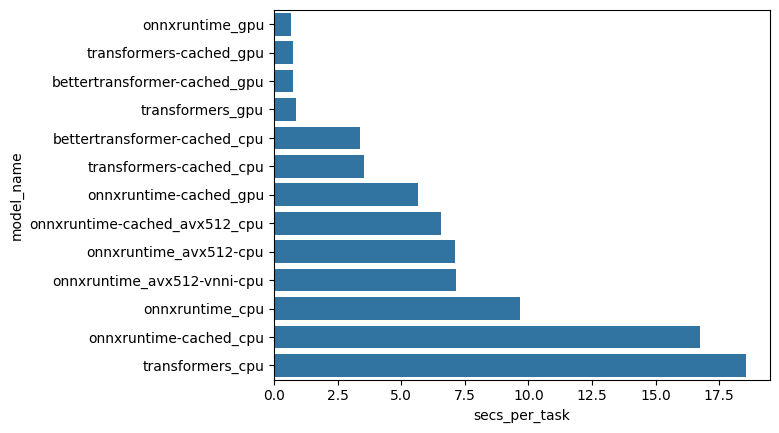

In [7]:
import seaborn as sns

sns.barplot(x="secs_per_task", y="model_name", data=df, color="blue")

<Axes: xlabel='memory (GB)', ylabel='model_name'>

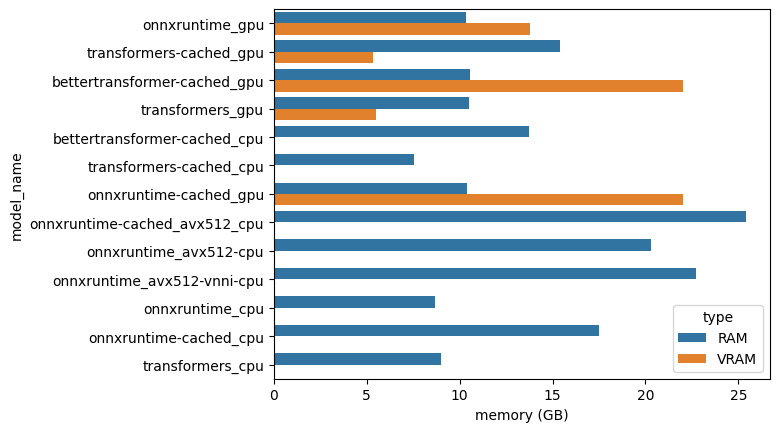

In [8]:
df_ram = df[["ram_gb", "model_name"]].rename(columns={"ram_gb": "memory (GB)"})
df_ram["type"] = "RAM"
df_vram = df[["vram_gb", "model_name"]].rename(columns={"vram_gb": "memory (GB)"})
df_vram["type"] = "VRAM"
df_mem = pd.concat([df_ram, df_vram])
sns.barplot(x="memory (GB)", y="model_name", hue="type", data=df_mem)